In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
from sklearn.datasets import load_boston

In [4]:
boston = load_boston()
X, y = sm.add_constant(pd.DataFrame(boston['data'], columns=boston['feature_names'])), pd.DataFrame(boston['target'], columns=['MEDV'])

In [5]:
model = sm.OLS(y, X)
rlt = model.fit()
rlt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Mon, 06 Sep 2021   Prob (F-statistic):          6.72e-135
Time:                        16:07:38   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.000      26.432      46.487
CRIM          -0.1080      0.033     -3.287      0.001      -0.173      -0.043
ZN             0.0464      0.014      3.382      0.001       0.019       0.073
INDUS          0.0206      0.061      0.334      0.738      -0.100       0.141
CHAS           2.6867      0.862      3.118      0.002       0.994       4.380
NOX          -17.7666      3.820     -4.651      0.000     -25.272     -10.262
RM             3.8099      0.418      9.116      0.000       2.989       4.631
AGE            0.0007      0.013      0.052      0.958      -0.025       0.027
DIS           -1.4756      0.199     -7.398      0.000      -1.867      -1.084
RAD            0.3060      0.066      4.613      0.000       0.176       0.436
TAX           -0.0123      0.004     -3.280      0.001      -0.020      -0.005
PTRATIO       -0.9527      0.131     -7.283      0.000      -1.210      -0.696
B              0.0093      0.003      3.467      0.001       0.004       0.015
LSTAT         -0.5248      0.051    -10.347      0.000      -0.624      -0.425
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
# 레버리지 확인.
# 선형회귀 모형의 결과 객체에는 influence 객체를 get_influence() 함수로 가져올 수 있다.
# influence 객체는 각 오브젝트의 레버리지와 cooks_distance를 제공해준다.
# 레버리지는 hat_matrix_diag 속성, cooks_distance는 cooks_distance 속성으로 얻을 수 있으며 cooks_distance 속성은 거리와 행렬로 반환되므로 첫 반환값을 사용한다.
influence = rlt.get_influence()
hat = influence.hat_matrix_diag

In [9]:
# 레버리지의 평균은 K / N이다.
# K는 독립변수의 개수, N은 오브젝트의 개수이다.
hat_mean = X.shape[1] / X.shape[0]

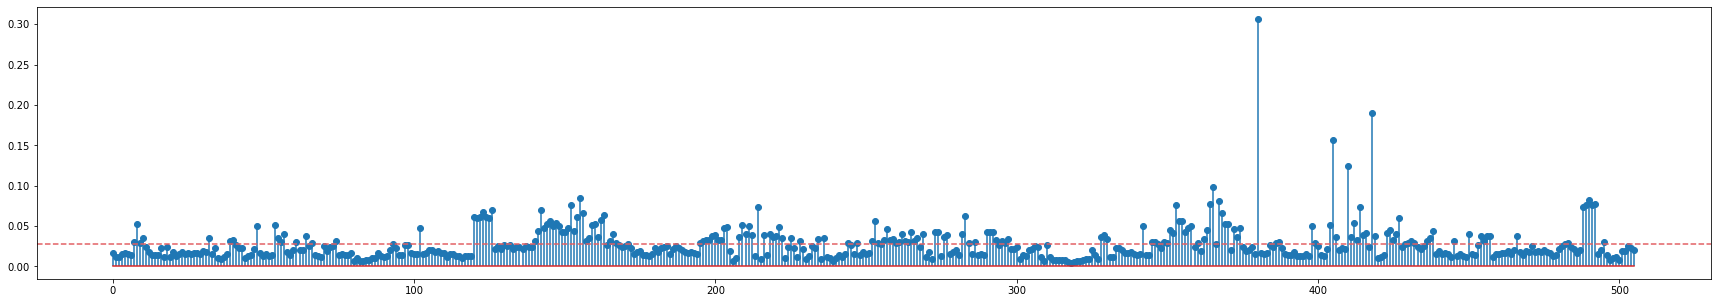

In [10]:
# stem은 1차원 데이터를 뿌릴 때 유용하게 사용되는 차트이다. axhline은 수평선을 그린다.
# 레버리지는 일반적으로 작으면 좋고 평균 레버리지보다 큰 레버리지를 가진 오브젝트는 잔차가 작지 않다면 제거 대상이 된다.
plt.figure(figsize=(30, 5))
plt.stem(hat)
plt.axhline(hat_mean, color='#e35f62', ls='--')
plt.show()

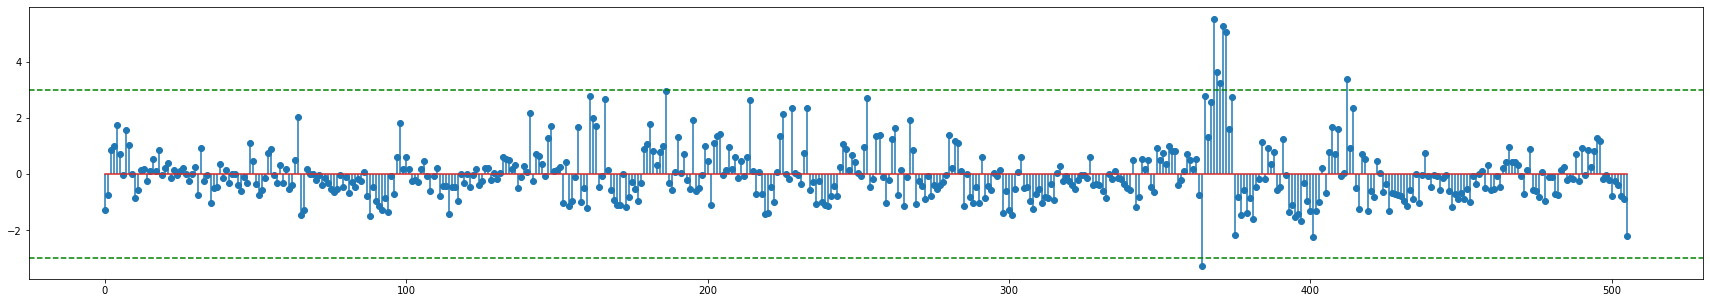

In [15]:
# 표준잔차 확인
# 표준잔차는 선형회귀 모델의 결과 객체가 resid_pearson으로 저장하고 있다. 이 값은 2 ~ 4보다 크면 아웃라이어로 판단할 수 있다.
# 여기선 3을 기준으로 잡고 -3 ~ 3 사이의 값만 정상값으로 판단했다.
plt.figure(figsize=(30, 5))
plt.stem(rlt.resid_pearson)
plt.axhline(3, color='g', ls='--')
plt.axhline(-3, color='g', ls='--')
plt.show()

In [23]:
# cooks_distance와 fox_recommendation으로 레버리지와 표준잔차 한 번에 적용해서 아웃라이어 걸러내기.
# fox_recommendation은 4 / (N - K - 1)이고 cooks_distance가 이 값보다 큰 오브젝트가 아웃라이어가 된다.
K, N = X.shape[1], X.shape[0]
fr = 4 / (N - K - 1)
cd, v = influence.cooks_distance
outlier_idx = np.where(cd > fr)[0]

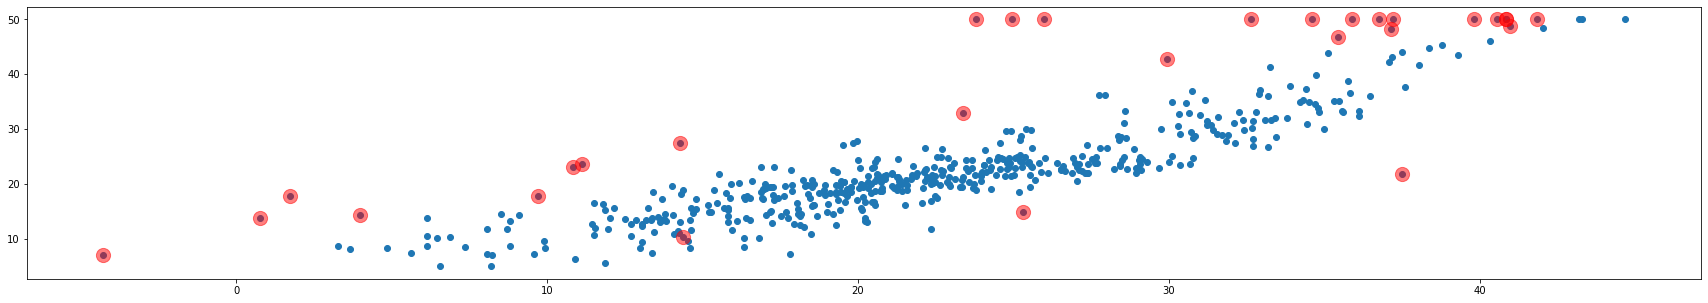

In [33]:
# 다차원의 선형회귀 결과를 산점도로 볼 때 예측값과 실제값의 산점도를 그릴 수 있다.
# 아웃라이어로 판단된 점들은 붉게 표시해본다.
plt.figure(figsize=(30, 5))
plt.scatter(rlt.predict(X), y)
plt.scatter(rlt.predict(X).iloc[outlier_idx].values, y.iloc[outlier_idx].values, color='r', alpha=0.5, s=200)
plt.show()

In [35]:
idx = list(set(list(range(N))).difference(outlier_idx))

In [37]:
X_new = X.iloc[idx, :]
y_new = y.iloc[idx,:]

In [38]:
model = sm.OLS(y_new, X_new)
rlt = model.fit()
rlt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     179.2
Date:                Mon, 06 Sep 2021   Prob (F-statistic):          3.07e-171
Time:                        16:24:12   Log-Likelihood:                -1231.5
No. Observations:                 477   AIC:                             2491.
Df Residuals:                     463   BIC:                             2549.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.7136      4.019      5.154      0.000      12.817      28.610
CRIM          -0.0906      0.028     -3.261      0.001      -0.145      -0.036
ZN             0.0397      0.010      4.071      0.000       0.021       0.059
INDUS         -0.0148      0.043     -0.342      0.732      -0.100       0.070
CHAS           1.3241      0.642      2.062      0.040       0.062       2.586
NOX          -10.6795      2.712     -3.938      0.000     -16.008      -5.351
RM             4.8902      0.365     13.385      0.000       4.172       5.608
AGE           -0.0221      0.010     -2.266      0.024      -0.041      -0.003
DIS           -1.1570      0.144     -8.053      0.000      -1.439      -0.875
RAD            0.2041      0.047      4.341      0.000       0.112       0.296
TAX           -0.0123      0.003     -4.741      0.000      -0.017      -0.007
PTRATIO       -0.7652      0.092     -8.332      0.000      -0.946      -0.585
B              0.0107      0.002      5.593      0.000       0.007       0.015
LSTAT         -0.3537      0.041     -8.572      0.000      -0.435      -0.273
==============================================================================
Omnibus:                       22.386   Durbin-Watson:                   1.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.186
Skew:                           0.464   Prob(JB):                     2.06e-06
Kurtosis:                       3.676   Cond. No.                     1.64e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""